# Outages and Storm EDA
Creator: [REDACTED]
This notebook is an EDA to understand the provided information and think about additional datasources to solve the problem.
The most relevant paper on OUTAGES can be seen [here](https://www.researchgate.net/publication/378737750_A_dataset_of_recorded_electricity_outages_by_United_States_county_2014-2022).

## Imports 

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

import utils_dhm as ut

## Configuration

In [2]:
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 200)

## Constants

In [3]:
# Eagle-I related data paths
YEAR = '2015'
EAGLEI_DATA_PATH = '../data/raw/dynamic-rhythms-train-data/data/eaglei_data/'
MCC_PATH = f'{EAGLEI_DATA_PATH}MCC.csv'
DQI_PATH = f'{EAGLEI_DATA_PATH}DQI.csv'

# NOAA Storm Events related data paths
#NOAA_DATA_PATH = '../data/raw/dynamic-rhythms-train-data/data/NOAA_StormEvents/'
#STORM_EVENTS_PATH = f'{NOAA_DATA_PATH}StormEvents_2014_2024.csv'
#STORM_DETAILS_PATH = f'{NOAA_DATA_PATH}StormEvents_details-ftp_v1.0_d2015_c20240716.csv'
NOAA_CLENADED_DATA_PATH = '../data/interim/storm_events_cleaned.csv'

# Relevance is determined by the amount of customers being affected, in this case we define
CUSTOMERS_OUT_NB = 1e4

## Functions

In [4]:
def get_outages_index(outages_county):
    outages_county = outages_county.sort_values("run_start_time")
    # Then we keep only the relevant outage (affecting a high amount of customers)
    outages_county = outages_county[outages_county.customers_out >= CUSTOMERS_OUT_NB]
    # We can define a sepparation of continuity to "divide" timelapses, in other words, sepparate outages events. 
    sepparation_hours = 18 # number of hours to define a sepparation between outages
    # We calculate the difference in seconds of each outage
    MIN_OUTAGE_SECONDS = 60 * 15 # Represents 15 minutes, in seconds
    NB_15_MIN_IN_HOUR = 4
    outages_county['second_difference'] = outages_county.run_start_time.diff().dt.total_seconds()
    # Each time we find an interval mark greater than the sepparation time (deffined in sepparation_hours), we identify it as true (1), or false (0).
    sepparation_hours_seconds = MIN_OUTAGE_SECONDS * NB_15_MIN_IN_HOUR * (sepparation_hours)
    outages_county['interval_mark'] = (outages_county.second_difference.fillna(MIN_OUTAGE_SECONDS) >= sepparation_hours_seconds).astype(int)
    # then we do the cumulativesum to "generate an index" of same representation. 
    outages_county['outage_index'] = outages_county['interval_mark'].cumsum() 
    return outages_county

## Read data

### Power Outages:
We have a range of datasets, going from eaglei_outages_2014 to eaglei_outages_2023.
[EAGLE-I](https://eagle-i.doe.gov) is an interactive geographic information system (GIS) that allows users to view and map the nation's energy infrastructure and obtain near real-time informational updates concerning the electric, petroleum and natural gas sectors within one visualization platform.
It contains information on the total number of customers out of power for every 15 minutes that starts at `run_start_time`

The EAGLE-I outage data represents 80% to 90% of utility customers nationally, with higher coverage rates later in our dataset. The coverage extent increased as additional parsing capabilities were developed and as data sharing agreements with other response agencies and utilities were formalized. If an electric utility is not included in EAGLE-I monitoring, that utility is omitted from EAGLE-I data calculations. If a county has no covered electric customers because all utilities (one or more) associated with that county are not monitored by EAGLE-I, then that county is omitted from EAGLE-I reports and data calculations. In 2014, 1,072 counties had no outage data collected, while in 2022, only 182 counties had no outage data collected, out of 3,222 total counties and county equivalents.
This is according to [[1]](https://www.nature.com/articles/s41597-024-03095-5)

In [5]:
outages = ut.get_required_outages_dfs(2014, 2015, 2016, eaglei_data_path=EAGLEI_DATA_PATH)

Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2014.csv.
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2015.csv.
Reading file: ../data/raw/dynamic-rhythms-train-data/data/eaglei_data/eaglei_outages_2016.csv.
Done.
Merging information.
Data is ready.


In [6]:
outages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27934641 entries, 0 to 13306023
Data columns (total 5 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   fips_code       int64 
 1   county          object
 2   state           object
 3   customers_out   int64 
 4   run_start_time  object
dtypes: int64(2), object(3)
memory usage: 1.2+ GB


### Storm Data
Storm data is provided by the National Oceanic and Atmospheric Administration (NOAA). There is a recompilation of storm event details from 2014 to 2024, with one .csv file for each year. These files are directly downloaded from NOAA's storm events public database.

In [7]:
storm_events = pd.read_csv(NOAA_CLENADED_DATA_PATH)
#storm_details = pd.read_csv(STORM_DETAILS_PATH)

## Understand Data

### Outages

#### Outages Dataset

`fips_code`: _Federal Information Processing System (FIPS) Codes for States and Counties
FIPS codes are numbers which uniquely identify geographic areas.  The number of 
digits in FIPS codes vary depending on the level of geography.  State-level FIPS
codes have two digits, county-level FIPS codes have five digits of which the 
first two are the FIPS code of the state to which the county belongs._

`customers_out`: Amount of affected customers (estimate) at a 15-minute interval from the `run_start_time` moment. 

`state` and `county`: Deffinition of where the outage ocurred. 

`run_start_time`: Datetime of information on the customers_out measurement.

In [8]:
outages.sample(5)

,fips_code,county,state,customers_out,run_start_time
1322309,13199,Meriwether,Georgia,1,2015-02-23 11:30:00
6601900,13031,Bulloch,Georgia,3,2015-07-17 15:00:00
998674,12101,Pasco,Florida,8,2014-12-03 16:30:00
1535669,48049,Brown,Texas,17,2014-12-24 20:30:00
3246900,54083,Randolph,West Virginia,4,2016-04-09 21:30:00


In [9]:
# Small data process
outages.run_start_time = pd.to_datetime(outages.run_start_time) # Transform into datetime to manipulate dates
outages = outages[outages.customers_out.notna()] # Filter nan values from customers_out
outages["state_id"] = outages.state.map(ut.STATE_ABBREVIATIONS) # Use the state abbreviations to get an ID
outages["fips_code_id"] = outages.fips_code.astype(str).str.zfill(5)
outages["sub_general_id"] = (outages.fips_code_id + '_' + outages.state_id)

In [10]:
#outages["general_id"] = (
#    outages.fips_code_id + '_' + 
#    outages.state_id + '_' + 
#    outages.run_start_time.dt.date.astype(str)
#)

In [11]:
#outages.sample(5)

In [12]:
# 15-Minute intervals
#general_id_aggregation = outages.general_id.value_counts()

In [13]:
#plt.figure(figsize=(10,15))
#general_id_aggregation.rename("Time intervals").value_counts().sort_index().plot(kind='barh')
#plt.title("Count of the General_ids with different information dates")
# 96 is the maximum since it represents 24 hours * 4  15-minute intervals each hour
# 1 is the minimum since it represents only one register was captured. 

In [14]:
# 96 Registers over time (representing a day from the beginning 00:00 to the end 24:00)
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==96
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

In [15]:
# 50 Registers over time (representing part of a day from the beginning (not necesarrily 00:00) to the end)
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==50
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

In [16]:
# Sometimes there is no continuous outage information within a day. 
#outages[
#    outages.general_id == general_id_aggregation[general_id_aggregation==10
#].sample(1).index.values[0]].plot(x='run_start_time', y='customers_out', marker='o')

Small conclusion: Days are non-important we need to tackle the problem mesuring the span of the outage.

<Axes: xlabel='run_start_time', ylabel='customers_out'>

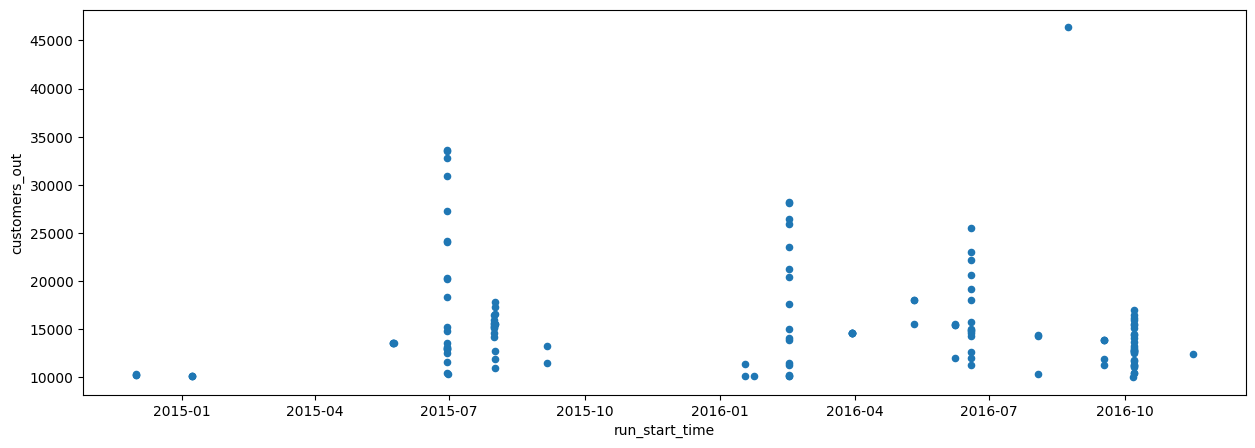

In [17]:
# In this initial test we grab a county
outage_test = outages[outages.sub_general_id=='12086_FL'].sort_values("run_start_time")
# Then we keep only the relevant outage (affecting a high amount of customers)
outage_test = outage_test[outage_test.customers_out >= CUSTOMERS_OUT_NB]

fig, ax = plt.subplots(figsize=(15,5))
outage_test.plot(x='run_start_time', y='customers_out', marker='o', ax=ax, kind='scatter')

<Axes: xlabel='run_start_time', ylabel='customers_out'>

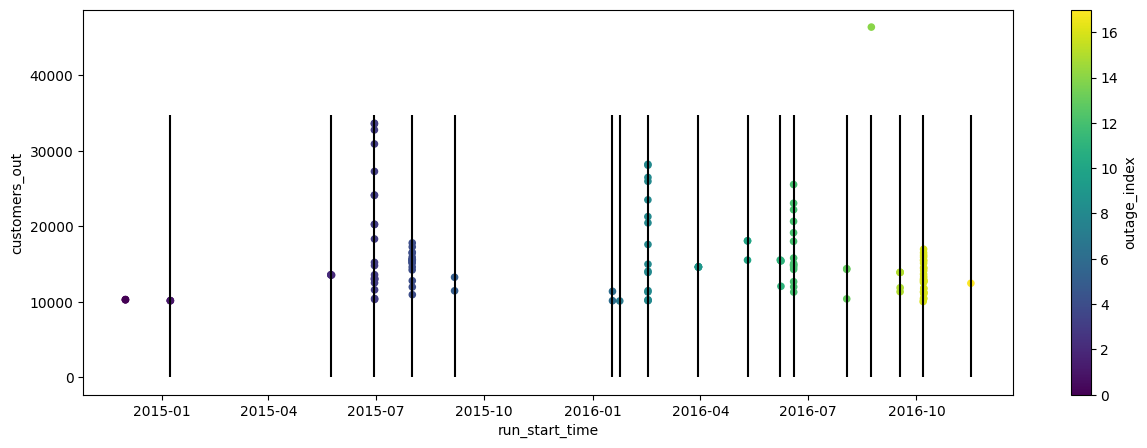

In [18]:
# We can define a sepparation of continuity to "divide" timelapses, in other words, sepparate outages events. 
sepparation_hours = 18 # number of hours to define a sepparation between outages
# We calculate the difference in seconds of each outage
MIN_OUTAGE_SECONDS = 60 * 15 # Represents 15 minutes, in seconds
NB_15_MIN_IN_HOUR = 4
outage_test['second_difference'] = outage_test.run_start_time.diff().dt.total_seconds()
# Each time we find an interval mark greater than the sepparation time (deffined in sepparation_hours), we identify it as true (1), or false (0).
sepparation_hours_seconds = MIN_OUTAGE_SECONDS * NB_15_MIN_IN_HOUR *(sepparation_hours)
outage_test['interval_mark'] = (outage_test.second_difference.fillna(MIN_OUTAGE_SECONDS) >= sepparation_hours_seconds).astype(int)
# then we do the cumulativesum to "generate an index" of same representation. 
outage_test['outage_index'] = outage_test['interval_mark'].cumsum() 

# We can plot the "different outages", divided with the interval marks
fig, ax = plt.subplots(figsize=(15,5))
intervals = outage_test[outage_test['interval_mark']==1]
plt.vlines(intervals.run_start_time, 0, outage_test.customers_out.max()*0.75, color='k')
outage_test.plot(x='run_start_time', y='customers_out', c='outage_index', marker='o', ax=ax, kind='scatter',cmap='viridis')

In [19]:
pd.set_option('display.max_rows', 200)
outage_test

,fips_code,county,state,customers_out,run_start_time,state_id,fips_code_id,sub_general_id,second_difference,interval_mark,outage_index
927068,12086,Miami-Dade,Florida,10247,2014-12-01 00:00:00,FL,12086,12086_FL,NaN,0,0
927332,12086,Miami-Dade,Florida,10251,2014-12-01 00:15:00,FL,12086,12086_FL,900.0,0,0
927582,12086,Miami-Dade,Florida,10282,2014-12-01 00:30:00,FL,12086,12086_FL,900.0,0,0
174867,12086,Miami-Dade,Florida,10133,2015-01-08 01:15:00,FL,12086,12086_FL,3285900.0,1,1
175301,12086,Miami-Dade,Florida,10125,2015-01-08 01:30:00,FL,12086,12086_FL,900.0,0,1
175731,12086,Miami-Dade,Florida,10125,2015-01-08 01:45:00,FL,12086,12086_FL,900.0,0,1
4071728,12086,Miami-Dade,Florida,13559,2015-05-24 00:15:00,FL,12086,12086_FL,11745000.0,1,2
4074111,12086,Miami-Dade,Florida,13543,2015-05-24 01:45:00,FL,12086,12086_FL,5400.0,0,2
4074481,12086,Miami-Dade,Florida,13533,2015-05-24 02:00:00,FL,12086,12086_FL,900.0,0,2
4093326,12086,Miami-Dade,Florida,13520,2015-05-24 16:45:00,FL,12086,12086_FL,53100.0,0,2


In [20]:
#outage_test.outage_index.value_counts().sort_index().plot(kind="barh")

Text(0, 0.5, 'count')

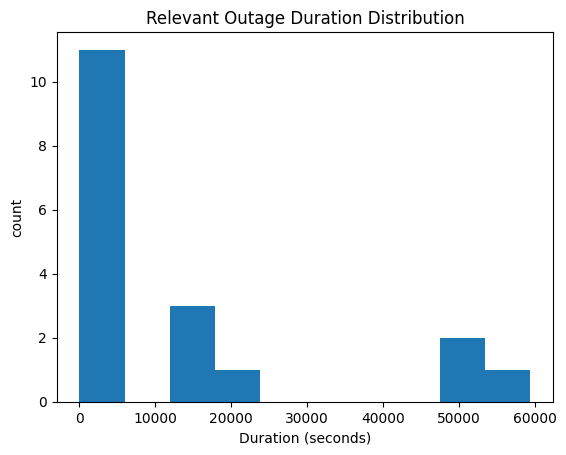

In [21]:
outage_test_summary = outage_test.groupby(
    'outage_index'
).agg(
    fips_code=('fips_code', 'first'),
    fips_code_id=('fips_code_id', 'first'),
    county=('county', 'first'),
    state=('state', 'first'),
    state_id=('state_id', 'first'),
    total_relevant_registers=('customers_out', 'count'),
    total_customers_out=('customers_out', 'sum'),
    run_start_time_min=('run_start_time', 'min'),
    run_start_time_max=('run_start_time', 'max'),
).reset_index()
outage_test_summary['general_id'] = outage_test_summary.fips_code_id + '__' + outage_test_summary.outage_index.astype(str).str.zfill(4)
outage_test_summary['outage_duration'] = (
    outage_test_summary.run_start_time_max - outage_test_summary.run_start_time_min
).dt.total_seconds()

plt.title("Relevant Outage Duration Distribution")
plt.hist(outage_test_summary.outage_duration)
plt.xlabel('Duration (seconds)')
plt.ylabel('count')

In [22]:
# Do the same for all counties
outages_index = outages.groupby('sub_general_id').apply(get_outages_index)
outages_index['outage_index_id'] = outages_index.fips_code_id + '__' + outages_index.outage_index.astype(str).str.zfill(4)
outages_index_resumed = outages_index.groupby(
    'outage_index_id'
).agg(
    fips_code=('fips_code', 'first'),
    fips_code_id=('fips_code_id', 'first'),
    county=('county', 'first'),
    state=('state', 'first'),
    state_id=('state_id', 'first'),
    total_relevant_registers=('customers_out', 'count'),
    total_customers_out=('customers_out', 'sum'),
    run_start_time_min=('run_start_time', 'min'),
    run_start_time_max=('run_start_time', 'max'),
).reset_index()

# We are adding the time interval of 15 miuntes to the last element. 
outages_index_resumed['run_start_time_max'] = outages_index_resumed['run_start_time_max'] + pd.to_timedelta(900, unit='s')

outages_index_resumed['outage_duration'] = (
    outages_index_resumed.run_start_time_max - outages_index_resumed.run_start_time_min
).dt.total_seconds()/3600/24 # We get the days of time difference

outages_index_resumed['outage_customers_over_duration'] = outages_index_resumed['total_customers_out']/outages_index_resumed['outage_duration']
outages_index_resumed['state'] = outages_index_resumed['state'].str.lower()

/tmp/ipykernel_28914/3235826873.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outages_index = outages.groupby('sub_general_id').apply(get_outages_index)


Text(0.5, 0, '(Duration) [days]')

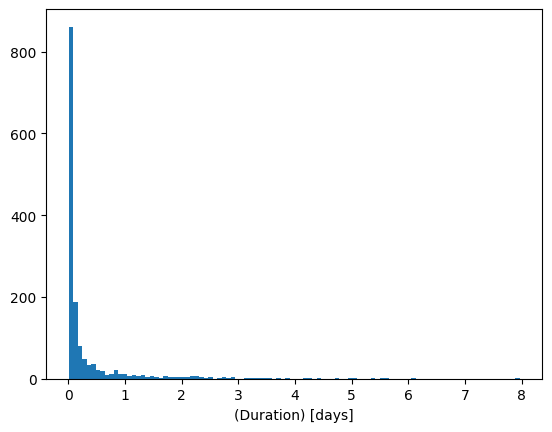

In [23]:
plt.hist(outages_index_resumed.outage_duration, bins=100,)
plt.xlabel('(Duration) [days]')

In [24]:
outages_index_resumed[outages_index_resumed.outage_duration==outages_index_resumed.outage_duration.max()]

,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
1418,53063__0002,53063,53063,Spokane,washington,WA,747,42833797,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06


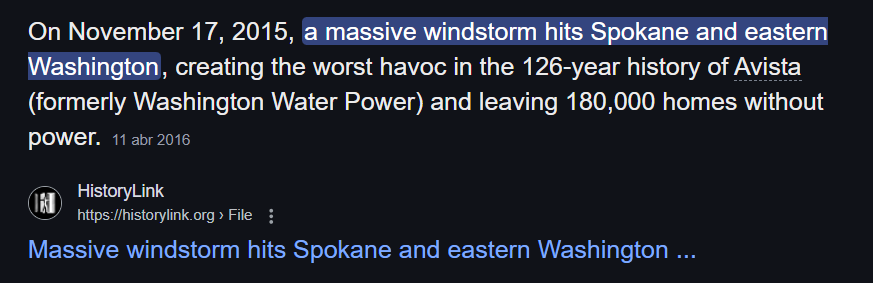

### Storms

#### Storm Events

In [25]:
#storm_events.columns, len(storm_events.columns)
storm_events.sample(5)

,Unnamed: 0,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,fips,fips__cz_name,new_fips
419514,419514,202005,14,2108,202005,14,2109,147613,888155,KANSAS,20,2020,May,Hail,C,115,MARION,ICT,14-MAY-20 21:08:00,CST-6,14-MAY-20 21:09:00,0,0,0,0,0.00K,0.00K,Fire Department/Rescue,0.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NW,BURNS,1.0,NW,BURNS,38.0900,-96.8900,38.0900,-96.8900,"Severe storms dropped lots of hail, produced s...",NaN,CSV,20115,20115MARION,20115
134883,134883,201606,15,1715,201606,15,1718,105138,640644,TENNESSEE,47,2016,June,Thunderstorm Wind,C,103,LINCOLN,HUN,15-JUN-16 17:15:00,CST-6,15-JUN-16 17:18:00,0,0,0,0,NaN,0.00K,Emergency Manager,52.00,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NNW,LINCOLN,1.0,NNW,LINCOLN,35.0370,-86.5291,35.0370,-86.5291,A band of strong to severe thunderstorms devel...,Trees were knocked down on Smith Mill Road.,CSV,47103,47103LINCOLN,47103
183288,183288,201712,4,1800,201712,5,1800,120869,724305,WISCONSIN,55,2017,December,Strong Wind,Z,58,DODGE,MKX,04-DEC-17 18:00:00,CST-6,05-DEC-17 18:00:00,0,0,0,0,4.00K,0.00K,Public,41.00,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An intensifying low pressure area from the Upp...,Sporadic minor to modest tree damage occurred.,CSV,55058,55058DODGE,55027
133741,133741,201602,19,702,201602,19,831,102660,613522,CALIFORNIA,6,2016,February,High Wind,Z,83,NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,MFR,19-FEB-16 07:02:00,PST-8,19-FEB-16 08:31:00,0,0,0,0,0.00K,0.00K,RAWS,53.00,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The last of a series of fronts brought high wi...,The Indian Well RAWS recorded a gust to 61 mph...,CSV,6083,06083NORTH CENTRAL & SOUTHEAST SISKIYOU COUNTY,6093
339377,339377,201908,22,1700,201908,22,1830,141858,851531,ARIZONA,4,2019,August,Flash Flood,C,23,SANTA CRUZ,TWC,22-AUG-19 17:00:00,MST-7,22-AUG-19 18:30:00,0,0,0,0,0.00K,0.00K,Social Media,NaN,NaN,Heavy Rain,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NW,DUQUESNE,4.0,WSW,DUQUESNE,31.3997,-110.7312,31.3436,-110.7439,Scattered thunderstorms occurred during the la...,Two to three inches of rain in a 2 hour period...,CSV,4023,04023SANTA CRUZ,4023


In [26]:
# Lets consider only County
#storm_events = storm_events#[storm_events.CZ_TYPE == 'C']

In [27]:
storm_events.EVENT_TYPE.value_counts()

EVENT_TYPE
Thunderstorm Wind             186450
Hail                           97652
Flash Flood                    43539
Winter Weather                 40154
High Wind                      38746
Drought                        32432
Winter Storm                   31878
Flood                          30209
Marine Thunderstorm Wind       25147
Heavy Snow                     24231
Tornado                        15641
Heat                           15437
Heavy Rain                     15310
Excessive Heat                 13803
Strong Wind                    11356
Extreme Cold/Wind Chill         9511
Dense Fog                       7567
Cold/Wind Chill                 6306
Frost/Freeze                    6100
Blizzard                        5889
High Surf                       4329
Wildfire                        3637
Lightning                       3609
Tropical Storm                  3184
Funnel Cloud                    3071
Ice Storm                       2566
Coastal Flood              

In [28]:
begin_datetime = (
    storm_events['BEGIN_YEARMONTH'].astype(str) + 
    storm_events['BEGIN_DAY'].astype(str).str.zfill(2) + 
    storm_events['BEGIN_TIME'].astype(str).str.zfill(4)
)

end_datetime = (
    storm_events['END_YEARMONTH'].astype(str) + 
    storm_events['END_DAY'].astype(str).str.zfill(2) + 
    storm_events['END_TIME'].astype(str).str.zfill(4)
)

storm_events['BEGIN_DATETIME'] = pd.to_datetime(begin_datetime,format='%Y%m%d%H%M')
storm_events['END_DATETIME'] = pd.to_datetime(end_datetime, format='%Y%m%d%H%M')
storm_events['DURATION_HOURS'] = (
    storm_events['END_DATETIME'] - storm_events['BEGIN_DATETIME']
).dt.total_seconds() / 3600

storm_events['fips_code_id'] = storm_events.new_fips.astype(str).str.zfill(5)

In [29]:
#storm_events.EPISODE_ID.value_counts().head(30)

`EPISODE_ID`: ID assigned by NWS to denote the storm episode; links the event details file with the
information within location file

`EVENT_ID`: Primary database key field.ID assigned by NWS to note a single, small part that goes into a specific storm episode; links the storm episode between the three files downloaded from SPC’s website. 

`STATE`: The state name where the event occurred

`STATE_FIPS`:A unique number (State Federal Information Processing Standard) is assigned to the county by the National Institute for Standards and Technology (NIST)

`CZ_TYPE`: Indicates whether the event happened in a (C) county/parish, (Z) zone or (M) marine.

`CZ_FIPS`: The county FIPS number is a unique number assigned to the county by the National Institute for Standards and Technology (NIST) or NWS Forecast Zone Number.

`CZ_NAME`:County/Parish, Zone or Marine Name assigned to the county FIPS number or NWS Forecast Zone.

`WFO`: National Weather Service Forecast Office’s area of responsibility (County Warning Area) in which the event occurred

`BEGIN_DATE_TIME`: Date and time that storm event began (MM/DD/YYYY 24 hour time AM/PM).

`CZ_TIMEZONE`:(Time Zone for the County/Parish, Zone or Marine Name) Eastern Standard Time (EST), Central Standard Time (CST), Mountain Standard Time (MST), etc.

`END_DATE_TIME`: Date and time that storm event ended (MM/DD/YYYY 24 hour time AM/PM).

For more information visit this [link](https://adata.site.wesleyan.edu/files/2017/08/Storm_Event_Data_Codebook.pdf).


In [30]:
#storm_events_test

In [31]:
drop_cols = [
    'BEGIN_YEARMONTH',
    'BEGIN_DAY',
    'BEGIN_TIME',
    'END_YEARMONTH',
    'END_DAY',
    'END_TIME',
    'MONTH_NAME',
    'YEAR',
    'WFO',
    'BEGIN_DATE_TIME',
    'END_DATE_TIME',
    'INJURIES_DIRECT',
    'INJURIES_INDIRECT',
    'DEATHS_DIRECT',
    'DEATHS_INDIRECT',
    'DAMAGE_PROPERTY',
    'DAMAGE_CROPS',
    'SOURCE',
    'MAGNITUDE',
    'MAGNITUDE_TYPE',
    'FLOOD_CAUSE',
    'CATEGORY',
    'TOR_F_SCALE',
    'TOR_LENGTH',
    'TOR_WIDTH',
    'TOR_OTHER_WFO',
    'TOR_OTHER_CZ_STATE',
    'TOR_OTHER_CZ_FIPS',
    'TOR_OTHER_CZ_NAME',
    'DATA_SOURCE'
]


/tmp/ipykernel_28914/570834128.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storm_events_test.drop(columns=drop_cols, inplace=True)


Text(0.5, 0, 'Time')

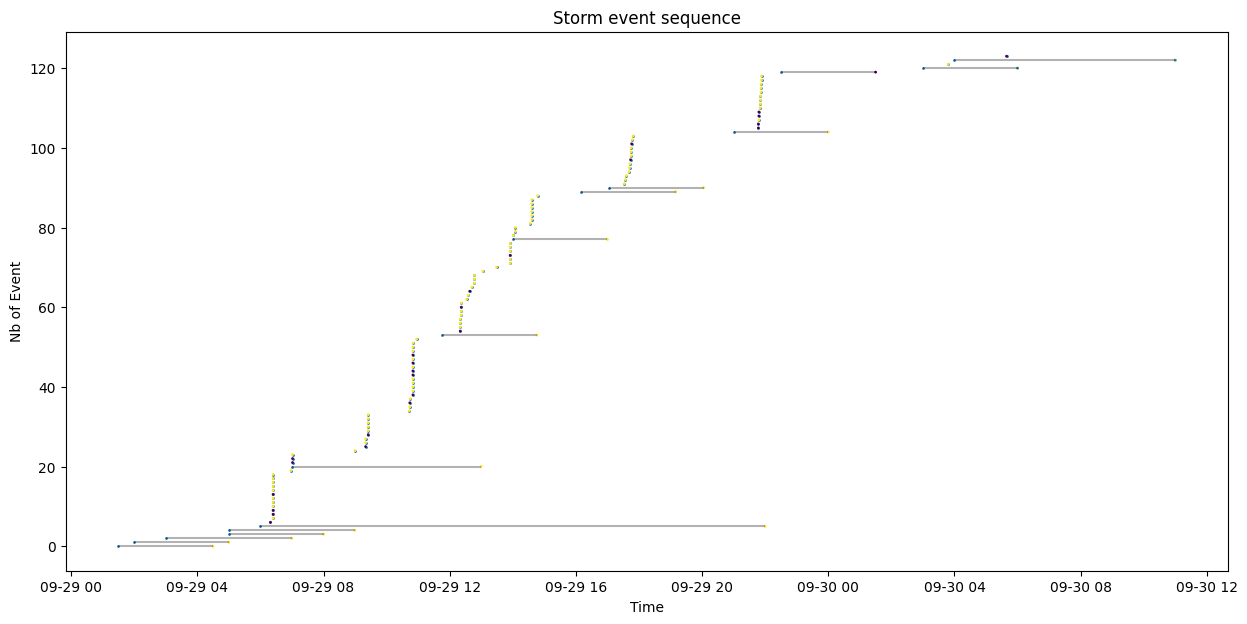

In [63]:
# Lets grab a sample
storm_events_test = storm_events[storm_events.EPISODE_ID==109423]
storm_events_test.drop(columns=drop_cols, inplace=True)
storm_events_test = storm_events_test.sort_values('BEGIN_DATETIME')#[storm_events_test.CZ_TYPE == 'C'].sort_values('BEGIN_DATETIME')
storm_events_test['sequence'] = range(storm_events_test.shape[0])

plt.figure(figsize=(15,7))
plt.scatter(storm_events_test.BEGIN_DATETIME, storm_events_test.sequence, s=1)
plt.scatter(storm_events_test.END_DATETIME, storm_events_test.sequence, s=1, c=storm_events_test.CZ_FIPS)
plt.hlines(storm_events_test.sequence, storm_events_test.BEGIN_DATETIME, storm_events_test.END_DATETIME, color='k', alpha=0.3)
plt.title('Storm event sequence')
plt.ylabel('Nb of Event')
plt.xlabel('Time')

In [35]:
storm_events.sample(1)

,Unnamed: 0,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,fips,fips__cz_name,new_fips,BEGIN_DATETIME,END_DATETIME,DURATION_HOURS,fips_code_id
148377,148377,201612,18,54,201612,18,54,112568,671655,TENNESSEE,47,2016,December,Hail,C,137,PICKETT,OHX,18-DEC-16 00:54:00,CST-6,18-DEC-16 00:54:00,0,0,0,0,0.00K,0.00K,Emergency Manager,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,SW,RED HILL,2.0,SW,RED HILL,36.6017,-85.1208,36.6017,-85.1208,A strong cold front moved through Middle Tenne...,Quarter size hail fell on Obey River Bridge in...,CSV,47137,47137PICKETT,47137,2016-12-18 00:54:00,2016-12-18 00:54:00,0.0,47137


In [36]:
# storm_events_grouped_fips = storm_events.sort_values(
#     'BEGIN_DATETIME'
# ).groupby(
#     ["EPISODE_ID", "fips_code_id"]
# ).agg(
#     nb_events=('EVENT_ID', 'count'),
#     affected_states=('STATE', 'first'),
#     affected_states_ids=('STATE_FIPS', 'first'),
#     distinct_events=('EVENT_TYPE', 'unique'),
#     touched_cz_names=('CZ_NAME', 'first'),
#     timezone=('CZ_TIMEZONE', 'first'),
#     episode_description=('EPISODE_NARRATIVE','first'),
#     begin_datetime=('BEGIN_DATETIME', 'min'),
#     end_datetime=('END_DATETIME', 'max'),
#     episode_narratives=('EPISODE_NARRATIVE', lambda x: list(x))
# ).reset_index()

# storm_events_grouped_fips['duration'] = ((storm_events_grouped_fips.end_datetime - storm_events_grouped_fips.begin_datetime).dt.total_seconds()/3600).replace(0, 0.01)
# storm_events_grouped_fips['state'] = storm_events_grouped_fips.affected_states.str.lower()

# storm_events_grouped_fips_with_outages = storm_events_grouped_fips.merge(
#     outages_index_resumed, 
#     on='fips_code_id', 
#     how='left',
# )

In [45]:
storm_episodes = storm_events.groupby(
    "EPISODE_ID"
).agg(
    nb_events=('EVENT_ID', 'count'),
    affected_states=('STATE', 'unique'),
    affected_states_ids=('STATE_FIPS', 'unique'),
    distinct_events=('EVENT_TYPE', 'unique'),
    fips_only_county_code_id=('CZ_FIPS', 'unique'),
    fips_code_id=('fips_code_id', 'unique'),
    touched_cz_names=('CZ_NAME', 'unique'),
    timezone=('CZ_TIMEZONE', 'unique'),
    episode_description=('EPISODE_NARRATIVE','first'),
    begin_datetime=('BEGIN_DATETIME', 'min'),
    end_datetime=('END_DATETIME', 'max'),
).reset_index()

storm_episodes['storm_duration'] = ((storm_episodes.end_datetime - storm_episodes.begin_datetime).dt.total_seconds()/3600).replace(0, 0.01)
storm_episodes['state'] = storm_episodes.affected_states.apply(lambda x: x[0]).str.lower()

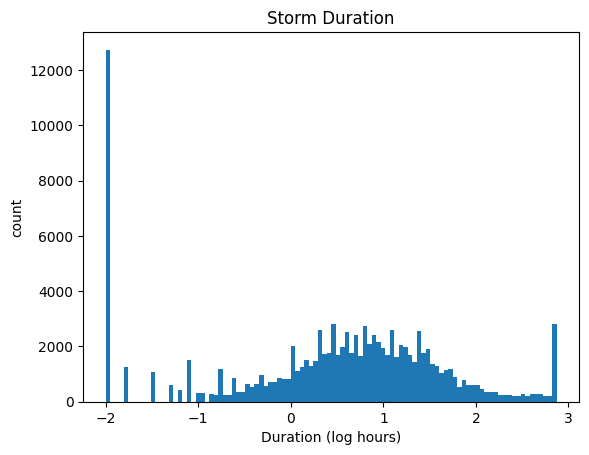

In [46]:
plt.title('Storm Duration')
plt.hist(np.log10(storm_episodes.storm_duration), bins=100)
plt.xlabel('Duration (log hours)')
plt.ylabel('count')
plt.show()

In [47]:
# This could be the minimum granularity level, which is storm episode, 
# however, we need to cross with the outages and see which counties were actually affected. 
storm_episodes.shape

(106934, 14)

In [48]:
storm_episodes.sample(5)

,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,fips_only_county_code_id,fips_code_id,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,storm_duration,state
35676,119851,2,[NEVADA],[32],[Thunderstorm Wind],"[15, 7]","[32015, 32007]","[LANDER, ELKO]",[PST-8],Thunderstorm winds partially blew off the roof...,2017-09-14 17:50:00,2017-09-14 20:20:00,2.500000,nevada
51844,137316,1,[TENNESSEE],[47],[Excessive Heat],[39],[47063],[HAMBLEN],[EST-5],A warm period with high pressure and strong mi...,2019-06-27 19:00:00,2019-06-27 19:00:00,0.010000,tennessee
34397,118481,3,[NEW YORK],[36],"[Flash Flood, Flood]","[119, 87]","[36119, 36087]","[WESTCHESTER, ROCKLAND]",[EST-5],Developing low pressure passing near the regio...,2017-07-07 10:15:00,2017-07-07 16:00:00,5.750000,new york
60354,146473,1,[GULF OF MEXICO],[85],[Marine Thunderstorm Wind],[850],[85850],[TARPON SPRINGS TO SUWANNEE RIVER FL OUT 20NM],[EST-5],A squall line pushed through West Central Flor...,2020-04-15 13:00:00,2020-04-15 13:00:00,0.010000,gulf of mexico
78210,165656,17,[INDIANA],[18],[Thunderstorm Wind],"[15, 23, 57, 95, 35, 97, 121, 11, 45, 165, 107]","[18015, 18023, 18057, 18095, 18035, 18097, 181...","[CARROLL, CLINTON, HAMILTON, MADISON, DELAWARE...",[EST-5],An anomalously moist environment that promoted...,2022-03-06 01:47:00,2022-03-06 03:37:00,1.833333,indiana


In [49]:
storms_state_exploded = storm_episodes.explode('fips_code_id')
storms_state_exploded['episode_fips_id'] = (
    storms_state_exploded.EPISODE_ID.astype(str) 
    + '_' 
    + storms_state_exploded.fips_code_id.astype(str).str.zfill(5)
)
storm_state_exploded_columns = [
    'EPISODE_ID',
    'fips_code_id',
    'episode_description',
    'begin_datetime',
    'end_datetime', 
    'storm_duration',
    'episode_fips_id'
]
storms_state_exploded = storms_state_exploded[storm_state_exploded_columns]
# This might be the minimum granulairity level, which is storms in counties, because the outages are at a 
# "county" granularity, a storm can have different meteorological instances in different counties and therefore 
# different impact. 
storms_state_exploded.sample(5)

,EPISODE_ID,fips_code_id,episode_description,begin_datetime,end_datetime,storm_duration,episode_fips_id
102106,191472,29157,A line of thunderstorms moved across Southeast...,2024-05-07 04:40:00,2024-05-07 04:40:00,0.010000,191472_29157
33830,117877,46049,A large upper level low pressure trough liftin...,2017-06-13 14:50:00,2017-06-13 19:30:00,4.666667,117877_46049
101300,190603,19105,"A strong system brought a mix of heavy rain, s...",2024-04-02 12:45:00,2024-04-03 18:00:00,29.250000,190603_19105
96961,185865,30004,A closed low pressure system over Washington a...,2023-10-24 02:00:00,2023-10-26 10:00:00,56.000000,185865_30004
104968,194583,17111,A system of thunderstorms moved over extreme n...,2024-08-06 02:15:00,2024-08-06 02:45:00,0.500000,194583_17111


### Outages and Storms

In [50]:
len(set(outages_index_resumed.fips_code_id.value_counts().index)-set(storms_state_exploded.fips_code_id.value_counts().index))

8

In [51]:
len(set(storms_state_exploded.fips_code_id.value_counts().index) - set(outages_index_resumed.fips_code_id.value_counts().index))

3600

In [52]:
storms_state_exploded.episode_fips_id.value_counts()

episode_fips_id
197269_12035    1
80464_39127     1
80465_54045     1
80465_54005     1
80465_54001     1
               ..
80469_37189     1
80468_51035     1
80468_51017     1
80468_51185     1
80468_51121     1
Name: count, Length: 412459, dtype: int64

In [53]:
storms_outages = storms_state_exploded.merge(
    outages_index_resumed, 
    on='fips_code_id', 
    how='left',
)

In [54]:
# outage_start_minus_storm_start must be positive, 
# if an outage starts before the storm there is something wrong, 

storms_outages['outage_start_minus_storm_start'] = (
    storms_outages['run_start_time_min'] - storms_outages['begin_datetime']
).dt.total_seconds()/3600/24 # This constraint is what defines a "legan" join, 
# if this doesn't fit, then the join can't be made.


storms_outages['outage_end_minus_storm_end'] = (
    storms_outages['run_start_time_max'] - storms_outages['end_datetime']
).dt.total_seconds()/3600/24

storms_outages['outage_start_minus_storm_end'] = (
    storms_outages['run_start_time_min'] - storms_outages['end_datetime']
).dt.total_seconds()/3600/24

storms_outages['outage_end_minus_storm_start'] = (
    storms_outages['run_start_time_max'] - storms_outages['begin_datetime']
).dt.total_seconds()/3600/24

In [55]:
days_after_storm_threshold = 1
storms_outages['storm_caused_outage_cond1'] = (storms_outages.outage_start_minus_storm_start >= 0)
storms_outages['storm_caused_outage_cond2'] = (storms_outages.outage_start_minus_storm_end <= 0)
storms_outages['storm_caused_outage_cond3'] = (storms_outages.outage_start_minus_storm_end.between(0, days_after_storm_threshold))

In [56]:
storm_outages_conditions = (
    (storms_outages.storm_caused_outage_cond1 & storms_outages.storm_caused_outage_cond2) |
    (storms_outages.storm_caused_outage_cond1 & storms_outages.storm_caused_outage_cond3)
)

storms_outages.loc[storm_outages_conditions, 'storm_caused_outage'] = 1
storms_outages.loc[~storm_outages_conditions, 'storm_caused_outage'] = 0
storms_outages['episode_fips_id'] = storms_outages.EPISODE_ID.astype(str) + '_' + storms_outages.fips_code_id.astype(str)

In [57]:
storms_caused_outages = storms_outages[storms_outages.storm_caused_outage==1]

In [58]:
storms_caused_outages.sample(5)

,EPISODE_ID,fips_code_id,episode_description,begin_datetime,end_datetime,storm_duration,episode_fips_id,outage_index_id,fips_code,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration,outage_start_minus_storm_start,outage_end_minus_storm_end,outage_start_minus_storm_end,outage_end_minus_storm_start,storm_caused_outage_cond1,storm_caused_outage_cond2,storm_caused_outage_cond3,storm_caused_outage
157467,111854,06107,The California drought continues during the mo...,2016-12-01 00:00:00,2016-12-31 23:59:00,743.983333,111854_06107,06107__0001,6107.0,Tulare,california,CA,1.0,16902.0,2016-12-12 19:15:00,2016-12-12 19:30:00,0.010417,1.622592e+06,11.802083,-19.186806,-19.197222,11.812500,True,True,False,1.0
146385,109512,18097,Multiple supercell thunderstorms produced a to...,2016-08-24 13:38:00,2016-08-24 18:21:00,4.716667,109512_18097,18097__0007,18097.0,Marion,indiana,IN,6.0,64245.0,2016-08-24 20:45:00,2016-08-24 22:15:00,0.062500,1.027920e+06,0.296528,0.162500,0.100000,0.359028,True,False,True,1.0
72069,93681,12057,Daytime heating combined with a potent upper l...,2015-04-20 14:17:00,2015-04-20 16:13:00,1.933333,93681_12057,12057__0000,12057.0,Hillsborough,florida,FL,3.0,35660.0,2015-04-20 21:45:00,2015-04-21 05:30:00,0.322917,1.104310e+05,0.311111,0.553472,0.230556,0.634028,True,False,True,1.0
86136,96578,48355,Abundant moisture over the region along with a...,2015-05-15 05:29:00,2015-05-15 16:30:00,11.016667,96578_48355,48355__0003,48355.0,Nueces,texas,TX,4.0,49128.0,2015-05-15 18:30:00,2015-05-15 19:45:00,0.052083,9.432576e+05,0.542361,0.135417,0.083333,0.594444,True,False,True,1.0
120690,103720,12033,Severe thunderstorms developed across the Flor...,2016-02-15 15:32:00,2016-02-15 18:33:00,3.016667,103720_12033,12033__0000,12033.0,Escambia,florida,FL,26.0,371178.0,2016-02-16 00:00:00,2016-02-16 06:30:00,0.270833,1.370503e+06,0.352778,0.497917,0.227083,0.623611,True,False,True,1.0


## Merging the values

In [59]:
storms_with_response_var = storms_state_exploded.merge(
    storms_caused_outages[
        ['storm_caused_outage',
         'episode_fips_id', 
         'outage_index_id', 
         'outage_start_minus_storm_start', 
         'outage_end_minus_storm_end',
         'outage_start_minus_storm_end', 
         'outage_end_minus_storm_start'
        ]
    ],
    how='left', 
    on='episode_fips_id'
)

In [60]:
storms_caused_outages.episode_fips_id.value_counts().value_counts()

count
1    792
2     21
4      2
5      1
Name: count, dtype: int64

In [75]:
storms_with_response_var.episode_fips_id.value_counts().value_counts()
# More than one accounts into a storm, that originates various outages, with a large amount of time between them
# so they can be classified as outages.

count
1    412435
2        21
4         2
5         1
Name: count, dtype: int64

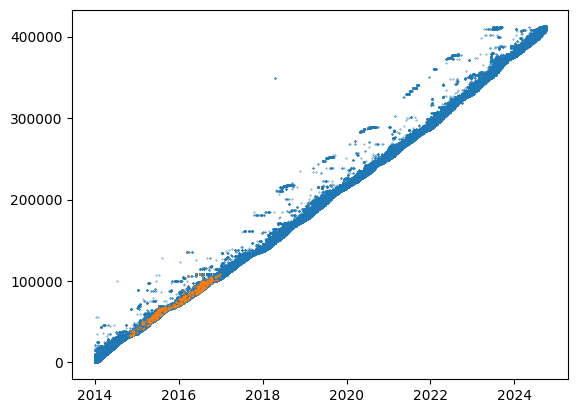

In [86]:
plt.scatter(storms_with_response_var.begin_datetime,storms_with_response_var.index, s=0.1)
plt.scatter(
    storms_with_response_var[storms_with_response_var.storm_caused_outage.notna()].begin_datetime,
    storms_with_response_var[storms_with_response_var.storm_caused_outage.notna()].index, s=0.1
)

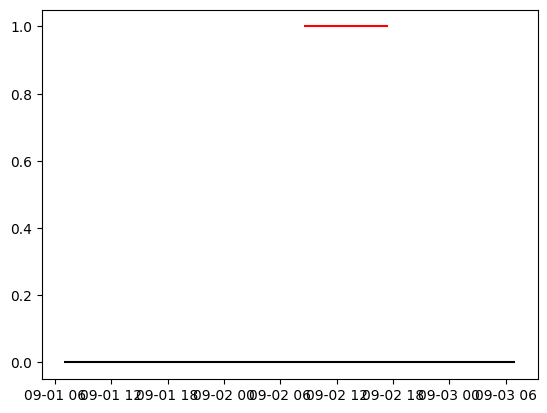

In [171]:
test = storms_that_caused_outages.sample(1)
test = test.reset_index().reset_index()
plt.hlines(test.level_0, test.begin_datetime, test.end_datetime, color='k')
plt.hlines(test.level_0 + 1, test.run_start_time_min, test.run_start_time_max, color='r')

In [172]:
storms_that_caused_outages

,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,fips_only_county_code_id,fips_code_id,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,duration,state_x,outage_index_id,fips_code,county,state_y,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration,outage_start_minus_storm_start,outage_end_minus_storm_end,outage_start_minus_storm_end,outage_end_minus_storm_start,storm_caused_outage_cond1,storm_caused_outage_cond2,storm_caused_outage_cond3
48118,90230,13,[PENNSYLVANIA],42,[Strong Wind],"[60, 62, 61, 54, 55, 104, 70, 71, 103, 105, 10...",42091,"[BERKS, NORTHAMPTON, LEHIGH, CARBON, MONROE, E...",[EST-5],An intense low pressure that passed east of Ne...,2014-11-02 08:00:00,2014-11-02 15:00:00,7.000000,pennsylvania,42091__0000,42091.0,Montgomery,pennsylvania,PA,19.0,236678.0,2014-11-02 15:15:00,2014-11-02 20:00:00,0.197917,1.195847e+06,0.302083,0.208333,0.010417,0.500000,True,False,True
48213,90252,6,[NEW YORK],36,[Strong Wind],"[176, 178, 71, 80, 78, 81]",36119,"[NORTHERN QUEENS, SOUTHERN QUEENS, SOUTHERN WE...",[EST-5],Deep low pressure passed south and east of Lon...,2014-11-02 02:00:00,2014-11-02 15:00:00,13.000000,new york,36119__0000,36119.0,Westchester,new york,NY,15.0,175314.0,2014-11-02 14:45:00,2014-11-02 18:30:00,0.156250,1.122010e+06,0.531250,0.145833,-0.010417,0.687500,True,True,False
48368,90288,9,[SOUTH CAROLINA],45,[Winter Weather],"[2, 7, 12, 1, 11, 19, 10, 6, 3]",45045,"[PICKENS MOUNTAINS, SPARTANBURG, LAURENS, OCON...",[EST-5],Precipitation associated with a strong upper l...,2014-11-01 02:00:00,2014-11-01 06:00:00,4.000000,south carolina,45045__0000,45045.0,Greenville,south carolina,SC,3.0,30449.0,2014-11-01 12:00:00,2014-11-01 15:15:00,0.135417,2.248542e+05,0.416667,0.385417,0.250000,0.552083,True,False,True
49635,90558,7,[MAINE],23,[Winter Storm],"[21, 28, 22, 25, 14, 27, 26]",23027,"[KENNEBEC, COASTAL WALDO, INTERIOR WALDO, SAGA...",[EST-5],Two areas of low pressure combined to produce ...,2014-11-02 07:00:00,2014-11-02 21:00:00,14.000000,maine,23027__0000,23027.0,Waldo,maine,ME,186.0,3079710.0,2014-11-02 20:00:00,2014-11-04 19:00:00,1.958333,1.572618e+06,0.541667,1.916667,-0.041667,2.500000,True,True,False
49638,90558,7,[MAINE],23,[Winter Storm],"[21, 28, 22, 25, 14, 27, 26]",23013,"[KENNEBEC, COASTAL WALDO, INTERIOR WALDO, SAGA...",[EST-5],Two areas of low pressure combined to produce ...,2014-11-02 07:00:00,2014-11-02 21:00:00,14.000000,maine,23013__0000,23013.0,Knox,maine,ME,209.0,3598802.0,2014-11-02 19:45:00,2014-11-05 00:45:00,2.208333,1.629646e+06,0.531250,2.156250,-0.052083,2.739583,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161631,112506,53,[GEORGIA],13,[Drought],"[70, 42, 66, 44, 21, 11, 7, 46, 67, 71, 24, 54...",13121,"[LAMAR, CARROLL, TROUP, SOUTH FULTON, CHEROKEE...",[EST-5],The D2 Severe drought conditions persisted ove...,2016-07-01 00:00:00,2016-07-31 23:59:00,743.983333,georgia,13121__0003,13121.0,Fulton,georgia,GA,8.0,101201.0,2016-07-06 17:00:00,2016-07-06 20:30:00,0.145833,6.939497e+05,5.708333,-25.145139,-25.290972,5.854167,True,True,False
161632,112506,53,[GEORGIA],13,[Drought],"[70, 42, 66, 44, 21, 11, 7, 46, 67, 71, 24, 54...",13121,"[LAMAR, CARROLL, TROUP, SOUTH FULTON, CHEROKEE...",[EST-5],The D2 Severe drought conditions persisted ove...,2016-07-01 00:00:00,2016-07-31 23:59:00,743.983333,georgia,13121__0004,13121.0,Fulton,georgia,GA,1.0,11101.0,2016-07-20 00:15:00,2016-07-20 00:30:00,0.010417,1.065696e+06,19.010417,-11.978472,-11.988889,19.020833,True,True,False
161678,112506,53,[GEORGIA],13,[Drought],"[70, 42, 66, 44, 21, 11, 7, 46, 67, 71, 24, 54...",13135,"[LAMAR, CARROLL, TROUP, SOUTH FULTON, CHEROKEE...",[EST-5],The D2 Severe drought conditions persisted ove...,2016-07-01 00:00:00,2016-07-31 23:59:00,743.983333,georgia,13135__0001,13135.0,Gwi

In [272]:
test = storms_that_caused_outages[storms_that_caused_outages.outage_index_id=='53063__0002']
test = test.loc[test.touched_cz_names.explode()[test.touched_cz_names.explode().str.contains(test.county.str.upper().unique()[0])].index]



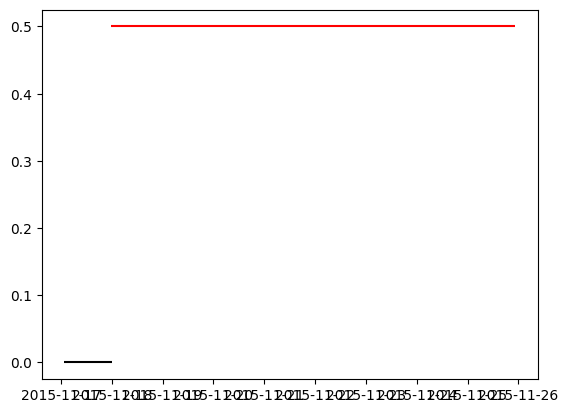

In [275]:
test2 = test.reset_index().reset_index()#storms_that_caused_outages[storms_that_caused_outages.outage_index_id=='53063__0002'].reset_index().reset_index()
plt.hlines(test2.level_0, test2.begin_datetime, test2.end_datetime, color='k')
plt.hlines(test2.level_0 + 0.5, test2.run_start_time_min, test2.run_start_time_max, color='r')

In [215]:
outages_index_resumed[outages_index_resumed.outage_duration==outages_index_resumed.outage_duration.max()]


,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
1418,53063__0002,53063,53063,Spokane,washington,WA,747,42833797,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06


In [214]:
storm_episodes[
    (storm_episodes.state=='washington') & (storm_episodes.begin_datetime>=pd.to_datetime('2015-11-01'))
]


,EPISODE_ID,nb_events,affected_states,affected_states_ids,distinct_events,touched_cz_fips,touched_cz_names,timezone,episode_description,begin_datetime,end_datetime,duration,state
17729,100553,7,[WASHINGTON],[53],"[Strong Wind, High Wind]","[559, 511, 558, 517, 555, 507, 503]","[BREMERTON AND VICINITY, HOOD CANAL AREA, SEAT...",[PST-8],Windy conditions lasted for several hours over...,2015-11-17 09:00:00,2015-11-17 15:00:00,6.000000,washington
17731,100555,29,[WASHINGTON],[53],"[High Wind, Dust Storm]","[36, 37, 34, 42, 35, 33, 38]","[SPOKANE AREA, NORTHEAST MOUNTAINS, MOSES LAKE...",[PST-8],An intense surface low pressure system moved f...,2015-11-17 01:36:00,2015-11-17 23:59:00,22.383333,washington
17857,100692,5,[WASHINGTON],[53],"[Flood, Heavy Rain]","[31, 33, 61, 9, 41]","[JEFFERSON, KING, SNOHOMISH, CLALLAM, LEWIS]",[PST-8],The Elwha River flexed its new muscles during ...,2015-11-14 00:00:00,2015-11-18 15:00:00,111.000000,washington
17907,100750,2,[WASHINGTON],[53],[Heavy Snow],[38],[OKANOGAN HIGHLANDS],[PST-8],A weather system dropped heavy localized snow ...,2015-11-23 20:00:00,2015-11-24 08:00:00,12.000000,washington
18006,100856,6,[WASHINGTON],[53],[High Wind],"[27, 520, 521, 29, 30, 28]","[YAKIMA VALLEY, EAST SLOPES OF THE WASHINGTON ...",[PST-8],A strong pacific system moved through the paci...,2015-11-17 10:00:00,2015-11-18 04:35:00,18.583333,washington
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106779,196736,1,[WASHINGTON],[53],[Wildfire],[37],[NORTHEAST MOUNTAINS],[PST-8],Upper Ruby Wildfire was started on August 20 b...,2024-09-01 00:00:00,2024-09-03 16:00:00,64.000000,washington
106780,196737,1,[WASHINGTON],[53],[Wildfire],[38],[OKANOGAN HIGHLANDS],[PST-8],The Goosmus Fire was started on September 25. ...,2024-09-25 13:48:00,2024-09-30 23:59:00,130.183333,washington
106782,196739,1,[WASHINGTON],[53],[Funnel Cloud],[11],[CLARK],[PST-8],A strong shower produced a funnel cloud near L...,2024-09-25 17:45:00,2024-09-25 17:46:00,0.016667,washington
106803,196772,1,[WASHINGTON],[53],[Wildfire],[47],[CENTRAL CHELAN COUNTY],[PST-8],The Pioneer Fire started on June 8 by unknown ...,2024-09-01 00:00:00,2024-09-30 23:59:00,719.983333,washington


In [220]:
outages_index_resumed[outages_index_resumed.fips_code_id=='53063']

,outage_index_id,fips_code,fips_code_id,county,state,state_id,total_relevant_registers,total_customers_out,run_start_time_min,run_start_time_max,outage_duration,outage_customers_over_duration
1416,53063__0000,53063,53063,Spokane,washington,WA,4,54009,2015-08-30 23:45:00,2015-08-31 00:45:00,0.041667,1.296216e+06
1417,53063__0001,53063,53063,Spokane,washington,WA,5,80379,2015-09-30 11:00:00,2015-09-30 13:15:00,0.093750,8.573760e+05
1418,53063__0002,53063,53063,Spokane,washington,WA,747,42833797,2015-11-17 23:30:00,2015-11-25 22:30:00,7.958333,5.382257e+06
1419,53063__0003,53063,53063,Spokane,washington,WA,6,74064,2015-12-29 00:30:00,2015-12-29 02:00:00,0.062500,1.185024e+06
1420,53063__0004,53063,53063,Spokane,washington,WA,6,74284,2016-08-08 00:15:00,2016-08-08 01:45:00,0.062500,1.188544e+06


In [217]:
storm_events[storm_events.CZ_NAME =='SPOKANE AREA']

,BEGIN_YEARMONTH,BEGIN_DAY,BEGIN_TIME,END_YEARMONTH,END_DAY,END_TIME,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_TYPE,CZ_FIPS,CZ_NAME,WFO,BEGIN_DATE_TIME,CZ_TIMEZONE,END_DATE_TIME,INJURIES_DIRECT,INJURIES_INDIRECT,DEATHS_DIRECT,DEATHS_INDIRECT,DAMAGE_PROPERTY,DAMAGE_CROPS,SOURCE,MAGNITUDE,MAGNITUDE_TYPE,FLOOD_CAUSE,CATEGORY,TOR_F_SCALE,TOR_LENGTH,TOR_WIDTH,TOR_OTHER_WFO,TOR_OTHER_CZ_STATE,TOR_OTHER_CZ_FIPS,TOR_OTHER_CZ_NAME,BEGIN_RANGE,BEGIN_AZIMUTH,BEGIN_LOCATION,END_RANGE,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,DATA_SOURCE,BEGIN_DATETIME,END_DATETIME,DURATION_HOURS
1961,201403,2,1150,201403,2,2330,83590,504732,WASHINGTON,53,2014,March,Heavy Snow,Z,36,SPOKANE AREA,OTX,02-MAR-14 11:50:00,PST-8,02-MAR-14 23:30:00,0,0,0,0,0.00K,0.00K,COOP Observer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The region was under a cold and dry air mass a...,NaN,CSV,2014-03-02 11:50:00,2014-03-02 23:30:00,11.666667
3328,201403,1,0,201403,1,500,83597,504767,WASHINGTON,53,2014,March,Strong Wind,Z,36,SPOKANE AREA,OTX,01-MAR-14 00:00:00,PST-8,01-MAR-14 05:00:00,0,0,0,0,5.00K,0.00K,Newspaper,38.0,MG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An Arctic front pushed into eastern Washington...,Power lines knocked down by toppled trees. An...,CSV,2014-03-01 00:00:00,2014-03-01 05:00:00,5.000000
8208,201407,19,1700,201407,23,1330,89055,536680,WASHINGTON,53,2014,July,Wildfire,Z,36,SPOKANE AREA,OTX,19-JUL-14 17:00:00,PST-8,23-JUL-14 13:30:00,0,0,0,0,2.00K,0.00K,Broadcast Media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The Watermelon Hill fire started in Lincoln Co...,The Watermelon Hill fire was wind fanned and q...,CSV,2014-07-19 17:00:00,2014-07-23 13:30:00,92.500000
8822,201407,14,1400,201407,14,1600,88211,536718,WASHINGTON,53,2014,July,Wildfire,Z,36,SPOKANE AREA,OTX,14-JUL-14 14:00:00,PST-8,14-JUL-14 16:00:00,0,0,0,0,4.00K,0.00K,Broadcast Media,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A closed upper-level low was positioned over E...,A brush fire on Old Miner Road off Mount Spoka...,CSV,2014-07-14 14:00:00,2014-07-14 16:00:00,2.000000
14959,201402,13,1100,201402,13,1200,82812,500839,WASHINGTON,53,2014,February,Strong Wind,Z,36,SPOKANE AREA,OTX,13-FEB-14 11:00:00,PST-8,13-FEB-14 12:00:00,0,0,0,0,1.00K,0.00K,Broadcast Media,39.0,EG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Conditions on the 12th of February were genera...,A large tree branch snapped off a tree and lan...,CSV,2014-02-13 11:00:00,2014-02-13 12:00:00,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603070,202308,18,1600,202308,31,2359,184916,1138825,WASHINGTON,53,2023,August,Wildfire,Z,36,SPOKANE AREA,OTX,18-AUG-23 16:00:00,PST-8,31-AUG-23 23:59:00,0,0,1,0,15.00M,0.00K,Emergency Manager,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,An incoming system brought strong winds and dr...,The fire started by unknown human causes 4 mil...,CSV,2023-08-18 16:00:00,2023-08-31 23:59:00,319.983333
615401,202307,31,1354,202307,31,2359,184228,1127067,WASHINGTON,53,2023,July,Wildfire,Z,36,SPOKANE AREA,OTX,31-JUL-23 13:54:00,PST-8,31-JUL-23 23:59:00,0,0,0,0,1.70M,0.00K,Fire Department/Rescue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,West Hallett Fire started on July 31 from unkn...,West Hallett started on July 31 from unknown c...,CSV,2023-07-31 13:54:00,2023-07-31 23:59:00,10.083333
633051,202402,25,1053,202402,26,220,189268,1164003,WASHINGTON,53,2024,February,Strong Wind,Z,36,SPOKANE AREA,OTX,25-FEB-24 10:53:00,PST-8,26-FEB-24 02:20:00,0,0,0,0,2.00K,0.00K,Utility Company,42.0,MG,NaN,NaN,Na

## References

In [317]:
otg = outages.drop_duplicates('fips_code_id')[['county', 'fips_code_id','state_id', 'state']]

In [313]:
se = storm_events[['STATE', 'STATE_FIPS', 'CZ_TYPE', 'CZ_FIPS', 'CZ_NAME']]
se['fips_code_id'] = (se.STATE_FIPS.astype(str).str.zfill(2) + se.CZ_FIPS.astype(str).str.zfill(3))
se.drop_duplicates('fips_code_id', inplace=True)

/tmp/ipykernel_28197/3749549476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se['fips_code_id'] = (se.STATE_FIPS.astype(str).str.zfill(2) + se.CZ_FIPS.astype(str).str.zfill(3))
/tmp/ipykernel_28197/3749549476.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  se.drop_duplicates('fips_code_id', inplace=True)


In [330]:
import geopandas as gpd
datapath = '../data/external/cb_2018_us_county_5m/cb_2018_us_county_5m.shp'
county = gpd.read_file(datapath)

In [368]:
STATE_ID = "01"
county_state = county[county.STATEFP==STATE_ID]
id_to_name_dict = county_state.set_index("GEOID")['NAME'].to_dict()
name_to_id_dict = county_state.set_index("NAME")['GEOID'].to_dict()

storm_events_state = se[se.STATE_FIPS.astype(str).str.zfill(2) == STATE_ID].sort_values('CZ_NAME')

In [386]:
for name, fips_id in name_to_id_dict.items():
    name_condition1 = storm_events_state.CZ_NAME.str.lower().str.contains(name.lower())
    name_condition2 = storm_events_state.CZ_NAME.str.lower().apply(lambda x: word_similarity(x, name)) > WORD_SIMILARITY_THRESHOLD
    storm_events_state.loc[((name_condition1)|(name_condition2)), 'new_id'] = fips_id

In [380]:
def word_similarity(w1, w2):
    similarity = SequenceMatcher(None, w1, w2).ratio()
    return similarity

In [392]:
county_state.sort_values('NAME')

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry
3043,01,001,00161526,0500000US01001,01001,Autauga,06,1539602123,25706961,"POLYGON ((-86.91759 32.66417, -86.81657 32.660..."
40,01,003,00161527,0500000US01003,01003,Baldwin,06,4117546676,1133055836,"POLYGON ((-88.02927 30.22271, -88.02399 30.230..."
3044,01,005,00161528,0500000US01005,01005,Barbour,06,2292144655,50538698,"POLYGON ((-85.74142 31.61961, -85.72983 31.632..."
2822,01,007,00161529,0500000US01007,01007,Bibb,06,1612167481,9602089,"POLYGON ((-87.42194 33.00338, -87.31854 33.006..."
774,01,009,00161530,0500000US01009,01009,Blount,06,1670103911,15015423,"POLYGON ((-86.96336 33.85822, -86.9202 33.8734..."
1822,01,011,00161531,0500000US01011,01011,Bullock,06,1613059160,6054988,"POLYGON ((-85.99916 32.25054, -85.98655 32.250..."
696,01,013,00161532,0500000US01013,01013,Butler,06,2012002530,2701198,"POLYGON ((-86.90894 31.96167, -86.85758 31.962..."
3035,01,015,00161533,0500000US01015,01015,Calhoun,06,1569189622,16627597,"POLYGON ((-86.14371 33.70913, -86.12388 33.710..."
2589,01,017,00161534,0500000US01017,01017,Chambers,06,1545085607,16971701,"POLYGON ((-85.59318 33.10734, -85.23244 33.108..."
3098,01,019,00161535,0500000US01019,01019,Cherokee,06,1433623321,120308339,"POLYGON ((-85.84384 34.24345, -85.82548 34.240..."


In [387]:
storm_events_state

,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,CZ_NAME,fips_code_id,new_id
16070,ALABAMA,1,Z,41,AUTAUGA,01041,01001
192062,ALABAMA,1,Z,264,BALDWIN CENTRAL,01264,01003
192060,ALABAMA,1,Z,266,BALDWIN COASTAL,01266,01003
192066,ALABAMA,1,Z,262,BALDWIN INLAND,01262,01003
16352,ALABAMA,1,Z,50,BARBOUR,01050,01005
2577,ALABAMA,1,Z,34,BIBB,01034,01007
952,ALABAMA,1,Z,17,BLOUNT,01017,01009
15168,ALABAMA,1,Z,46,BULLOCK,01046,01011
1492,ALABAMA,1,C,15,CALHOUN,01015,01015
1416,ALABAMA,1,Z,19,CALHOUN,01019,01015


In [389]:
se[se.STATE_FIPS.astype(str).str.zfill(2) == STATE_ID].sort_values('CZ_NAME')

,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,CZ_NAME,fips_code_id
16070,ALABAMA,1,Z,41,AUTAUGA,01041
192062,ALABAMA,1,Z,264,BALDWIN CENTRAL,01264
192060,ALABAMA,1,Z,266,BALDWIN COASTAL,01266
192066,ALABAMA,1,Z,262,BALDWIN INLAND,01262
16352,ALABAMA,1,Z,50,BARBOUR,01050
2577,ALABAMA,1,Z,34,BIBB,01034
952,ALABAMA,1,Z,17,BLOUNT,01017
15168,ALABAMA,1,Z,46,BULLOCK,01046
1492,ALABAMA,1,C,15,CALHOUN,01015
1416,ALABAMA,1,Z,19,CALHOUN,01019


In [349]:
from difflib import SequenceMatcher

In [367]:
s = se[~se.fips_code_id.isin(otg.fips_code_id)]
s[s.STATE_FIPS==1].sort_values(['STATE_FIPS','CZ_NAME'])

,STATE,STATE_FIPS,CZ_TYPE,CZ_FIPS,CZ_NAME,fips_code_id
192062,ALABAMA,1,Z,264,BALDWIN CENTRAL,01264
192060,ALABAMA,1,Z,266,BALDWIN COASTAL,01266
192066,ALABAMA,1,Z,262,BALDWIN INLAND,01262
16352,ALABAMA,1,Z,50,BARBOUR,01050
2577,ALABAMA,1,Z,34,BIBB,01034
952,ALABAMA,1,Z,17,BLOUNT,01017
15168,ALABAMA,1,Z,46,BULLOCK,01046
1416,ALABAMA,1,Z,19,CALHOUN,01019
1492,ALABAMA,1,C,15,CALHOUN,01015
15461,ALABAMA,1,Z,38,CHAMBERS,01038


In [390]:
#otg[otg.state=='Alabama'].sort_values('county')

In [294]:
#outages_fips = outages.fips_code.astype(str).str.zfill(5).unique()#outages_index_resumed.fips_code_id.unique()

In [286]:
storm_fips = (storm_events.STATE_FIPS.astype(str).str.zfill(2) + storm_events.CZ_FIPS.astype(str).str.zfill(3)).unique()

In [296]:
len(set(storm_fips)-set(outages_fips))

3558

In [297]:
len(set(outages_fips)-set(storm_fips))

6